# Augmentation Script
This notebook contains the augmentation functions and main logic from the `Augmentation.py` script.

In [60]:
from scipy.ndimage import gaussian_filter, map_coordinates
from PIL import Image
import numpy as np
import random
import sys
import cv2
import os

## Load Image Function

In [61]:
def load_image(image_path):
    """Load an image using OpenCV in RGB format.

    Args:
        image_path (str): Path to the image file.

    Raises:
        FileNotFoundError: If the image file cannot be found or read.
        ImportError: If OpenCV is not installed correctly.

    Returns:
        np.ndarray: The loaded image in RGB format.
    """
    try:
        if not hasattr(cv2, 'imread') or not hasattr(cv2, 'cvtColor'):
            raise ImportError(
                "OpenCV (cv2) is not installed correctly or there is a naming conflict."
            )
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Could not read image {image_path}")
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error in load_image: {e}")
        sys.exit(1)

## Save Image Function

In [62]:
def save_image(image, original_path, suffix):
    """Save the image with the original filename and the augmentation type.

    Args:
        image (np.ndarray): The image to save.
        original_path (str): Path to the original image file.
        suffix (str): Suffix to append to the filename.
    """
    try:
        script_dir = os.getcwd()
        filename = os.path.basename(original_path)
        name, ext = os.path.splitext(filename)
        new_filename = f"{name}_{suffix}{ext}"
        save_path = os.path.join(script_dir, new_filename)
        Image.fromarray(image).save(save_path)
    except Exception as e:
        print(f"Error in save_image: {e}")
        sys.exit(1)

## Flip Image Function

In [63]:
def flip_image(image):
    """Flip the image horizontally. """
    try:
        return cv2.flip(image, 1)
    except Exception as e:
        print(f"Error in flip_image: {e}")
        raise

## Rotate Image Function

In [64]:
def rotate_image(image):
    """Rotate the image by a random angle between -30 and 30 degrees."""
    try:
        angle = random.uniform(-30, 30)
        h, w = image.shape[:2]
        M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
        return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    except Exception as e:
        print(f"Error in rotate_image: {e}")
        raise

## Skew Image Function

In [65]:
def skew_image(image):
    """Apply a random perspective skew."""
    try:
        h, w = image.shape[:2]
        src_pts = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
        dst_pts = np.float32([
            [random.uniform(0, w * 0.2), random.uniform(0, h * 0.2)],
            [w - random.uniform(0, w * 0.2), random.uniform(0, h * 0.2)],
            [random.uniform(0, w * 0.2), h - random.uniform(0, h * 0.2)],
            [w - random.uniform(0, w * 0.2), h - random.uniform(0, h * 0.2)]
        ])
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        return cv2.warpPerspective(
            image, M, (w, h), borderMode=cv2.BORDER_REFLECT
        )
    except Exception as e:
        print(f"Error in skew_image: {e}")
        raise

## Shear Image Function

In [66]:
def shear_image(image):
    """Apply a shear transformation."""
    try:
        h, w = image.shape[:2]
        M = np.float32([[1, random.uniform(-0.3, 0.3), 0], [0, 1, 0]])
        return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    except Exception as e:
        print(f"Error in shear_image: {e}")
        raise

## Crop Image Function

In [67]:
def crop_image(image):
    """Randomly crop a part of the image."""
    try:
        h, w = image.shape[:2]
        crop_size = random.uniform(0.6, 0.9)
        new_h, new_w = int(h * crop_size), int(w * crop_size)
        top = random.randint(0, h - new_h)
        left = random.randint(0, w - new_w)
        return image[top:top + new_h, left:left + new_w]
    except Exception as e:
        print(f"Error in crop_image: {e}")
        raise

## Elastic Distortion Function

In [68]:
def elastic_distortion(image, alpha=40, sigma=6):
    """Apply elastic transformation (distortion)."""
    try:
        random_state = np.random.RandomState(None)
        shape = image.shape
        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode='constant', cval=0) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode='constant', cval=0) * alpha
        dz = np.zeros_like(dx)
        x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
        indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1)), np.reshape(z, (-1, 1))
        return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
    except Exception as e:
        print(f"Error in elastic_distortion: {e}")
        raise

## Augment Image Function

In [69]:
def augment_image(image_path):
    """Apply all augmentations and save images."""
    try:
        image = load_image(image_path)
        augmentations = {
            'flip': flip_image,
            'rotate': rotate_image,
            'skew': skew_image,
            'shear': shear_image,
            'crop': crop_image,
            'elastic': elastic_distortion
        }
        for name, func in augmentations.items():
            augmented_image = func(image)
            save_image(augmented_image, image_path, name)
    except Exception as e:
        print(f"Error in augment_image: {e}")
        raise

## Show Stored Images

In [70]:
def show_stored_images(filename):
  """ Show stored images. """
  from glob import glob
  import matplotlib.pyplot as plt
  import cv2

  suffixes = ['_crop', '_elastic', '_flip', '_rotate', '_skew', '_shear']
  file_list = []
  for suffix in suffixes:
      file_list.extend(glob(f"*{suffix}.*"))

  for filename in set(file_list):
      image = cv2.imread(filename)
      if image is not None:
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          plt.figure(figsize=(6,4))
          plt.imshow(image)
          plt.title(filename)
          plt.axis('off')
  plt.show()

## Main Function

In [71]:
def main():
    augment_image('/content/image1.JPG')
    show_stored_images('/content/image1.JPG')

## Run Main Function

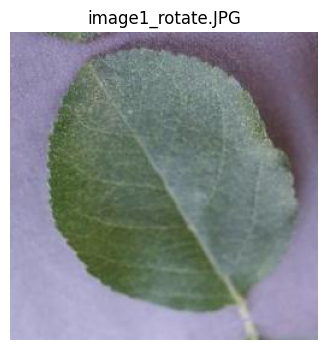

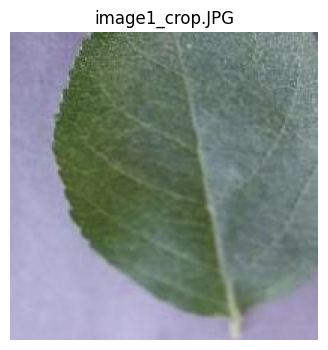

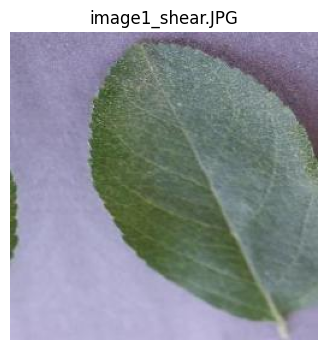

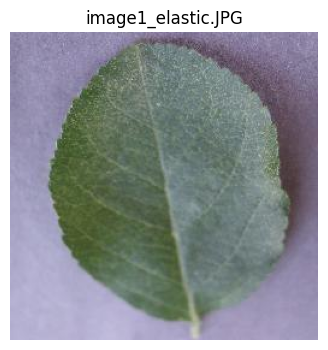

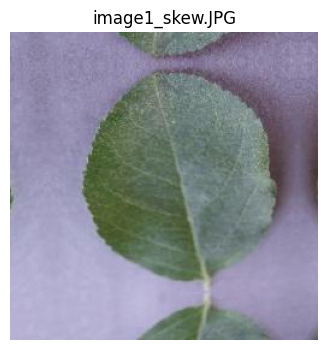

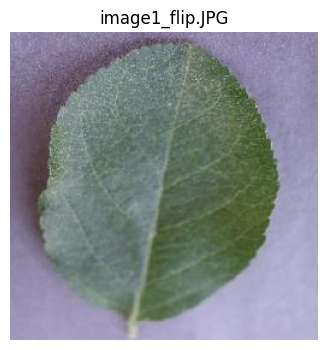

In [72]:
main()